In [1]:
import PIL
import datetime
from time import sleep
import os
from os import listdir as ls
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import albumentations as A
from albumentations.pytorch import ToTensor

from torch.utils.tensorboard import SummaryWriter

plt.ion()
%load_ext tensorboard
%matplotlib inline

In [61]:
!kill 2464

In [60]:
!top

=top - 10:01:27 up 92 days, 20:18,  6 users,  load average: 3.56, 3.90, 3.67
Tasks:  29 total,   1 running,  27 sleeping,   0 stopped,   1 zombie
%Cpu(s):  7.8 us,  0.8 sy,  0.0 ni, 91.3 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 52826489+total, 43276328 free, 66467436 used, 41852115+buff/cache
KiB Swap:        0 total,        0 free,        0 used. 45616457+avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
11718 semyon    20   0 23.600g 3.314g 567320 S   6.7  0.7   5:02.74 ZMQbg/1     
    1 root      20   0   21416   3416   3124 S   0.0  0.0   0:00.04 bash        
   87 root      20   0   65512   3792   3076 S   0.0  0.0   0:00.01 sshd        
   89 root      20   0   21608   3656   3260 S   0.0  0.0   0:00.00 bash        
  188 semyon    20   0  920836  96252  15668 S   0.0  0.0   0:42.15 ZMQbg/1     
  220 semyon    20   0 12.002g 323676 142752 S   0.0  0.1   0:42.25 ZMQbg/1     
 2464 semyon    20   0 2992724 365688 136832 S   0.0 

In [62]:
train_log_dir = os.path.join(".././logs/tensorboard/train/",
                                datetime.datetime.now().strftime("%Y-%m-%d_%H-%m"))
print('nohup tensorboard --logdir='+train_log_dir+' &')
os.makedirs(train_log_dir, exist_ok=True)

nohup tensorboard --logdir=.././logs/tensorboard/train/2019-05-22_10-05 &


In [2]:
train_log_dir = '.././logs/tensorboard/train/2019-05-21_15-05'

In [63]:
train_summary_writer = SummaryWriter(train_log_dir)

In [64]:
def show_example(example):
    """
    Show image with labels
    Args:
    example: dict or image(ndarray)
    """
    plt.figure()
    if isinstance(example, dict):
        image = example['image']
        plt.title(str(example['labels']))
    else:
        image = example
    plt.imshow(image)
    plt.show()  
    

def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['labels']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    print('Batch shape', images_batch.size())

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
    

def show_train_batches(dataloader, i):
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['labels'].size())

        if i_batch == i:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

In [65]:
class ChestnetDataset(Dataset):
    """Chest X-ray picture dataset annotated with patologies"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = cv2.imread(img_name)
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.iloc[idx, 1:-1].values.astype(int)
        sample = {'image': image, 'labels': labels}

        if self.transform:
            # Apply tranform to numpy.ndarray which represents sample image
            augmented = self.transform(image=sample['image'])
            sample['image'] = augmented['image']
            sample['labels'] = torch.from_numpy(sample['labels']).float()
        return sample

In [66]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit = 0.1),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensor()
])
val_transform = A.Compose([ 
    A.Resize(256, 256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensor()
])

        
fold_titles = [('fold1234', 'fold0'),('fold0234', 'fold1'),('fold0134', 'fold2'),('fold0124', 'fold3'),('fold0123', 'fold4')]
folds = dict() # {'fold0': (train_dl0, val_dl0),...,'fold4' : (train_dl4, val_dl4)}
for train, val in fold_titles:
    print(train, val)
    train_dataset = ChestnetDataset(os.path.join('../dataset/', train+'.csv'), 
                                    '../../../datasets/ilyas/ChestNets/images/',
                                    transform=train_transform)
    val_dataset = ChestnetDataset(os.path.join('../dataset/', val+'.csv'), 
                                  '../../../datasets/ilyas/ChestNets/images/',
                                  transform=val_transform)

    train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
    val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)
    folds[val] = (train_dl, val_dl)
folds

fold1234 fold0
fold0234 fold1
fold0134 fold2
fold0124 fold3
fold0123 fold4


{'fold0': (<torch.utils.data.dataloader.DataLoader at 0x7f2620689ac8>,
  <torch.utils.data.dataloader.DataLoader at 0x7f26206896a0>),
 'fold1': (<torch.utils.data.dataloader.DataLoader at 0x7f26206894e0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f26207cb160>),
 'fold2': (<torch.utils.data.dataloader.DataLoader at 0x7f26207cb320>,
  <torch.utils.data.dataloader.DataLoader at 0x7f26207576d8>),
 'fold3': (<torch.utils.data.dataloader.DataLoader at 0x7f26207570b8>,
  <torch.utils.data.dataloader.DataLoader at 0x7f26207575f8>),
 'fold4': (<torch.utils.data.dataloader.DataLoader at 0x7f2620757f60>,
  <torch.utils.data.dataloader.DataLoader at 0x7f26207574a8>)}

0 torch.Size([32, 3, 256, 256]) torch.Size([32, 14])
1 torch.Size([32, 3, 256, 256]) torch.Size([32, 14])
2 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 256, 256]) torch.Size([32, 14])
Batch shape torch.Size([32, 3, 256, 256])


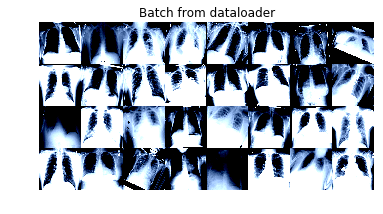

In [67]:
train_dataset = ChestnetDataset('../dataset/sample_train.csv', '../../../datasets/ilyas/ChestNets/images/',
                                           transform=train_transform)
val_dataset = ChestnetDataset('../dataset/sample_val.csv', '../../../datasets/ilyas/ChestNets/images/',
                                           transform=val_transform)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)



show_train_batches(train_dl, 2)

In [68]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def new_densenet121():
    net = torchvision.models.densenet121()
    state_dict = torch.load('../weights/densenet121_pretrained.pth')
    # '.'s are no longer allowed in module names, but pervious _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key] 
    net.load_state_dict(state_dict)
    num_ftrs = net.classifier.in_features
    net.classifier = nn.Linear(num_ftrs, 14)
    return net.to(device);

In [69]:
def perform_training_epoch(model, criterion, optimizer, scheduler=None):
    model.train()
    train_average_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs
        inputs, labels = data['image'].to(device), data['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_average_loss += loss.item()
    train_average_loss /= len(train_dl)
    return train_average_loss

def compute_validation_loss(model, criterion):
    model.eval()
    val_average_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dl, 0):
            inputs, labels = data['image'].to(device), data['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_average_loss += loss.item()
    val_average_loss /= len(val_dl)
    return val_average_loss

In [70]:
def train(model, criterion, optimizer, train_dl, val_dl, save_title='test', num_epochs=30):
    
    for epoch in tqdm(range(num_epochs)):  
        train_average_loss = perform_training_epoch(model, criterion, optimizer)
        val_average_loss = compute_validation_loss(model, criterion)
        
        train_summary_writer.add_scalar('train_loss '+save_title, train_average_loss, global_step = epoch)
        train_summary_writer.add_scalar('val_loss '+save_title, val_average_loss, global_step = epoch)
        train_summary_writer.close()
        
        torch.save(model.state_dict(), '../weights/densenet_'+save_title+'_epoch'+str(epoch)+'.pth')
        print(save_title+' [%d] train_loss: %.3f; val_loss: %.3f' % (epoch + 1, train_average_loss, val_average_loss))
    
    print('Finished Training')

In [55]:
%%time

models = {key: new_densenet121() for key in folds.keys()}
for key, (train_dl, val_dl) in folds.items():
    print(key, train_dl, val_dl)
    model = models[key]
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(model, criterion, optimizer, train_dl, val_dl, save_title=key)

fold0 <torch.utils.data.dataloader.DataLoader object at 0x7f2620710f28> <torch.utils.data.dataloader.DataLoader object at 0x7f26223e1080>
fold1 <torch.utils.data.dataloader.DataLoader object at 0x7f26216a72b0> <torch.utils.data.dataloader.DataLoader object at 0x7f26216a7588>
fold2 <torch.utils.data.dataloader.DataLoader object at 0x7f2620bbdcc0> <torch.utils.data.dataloader.DataLoader object at 0x7f2622500390>
fold3 <torch.utils.data.dataloader.DataLoader object at 0x7f26225005c0> <torch.utils.data.dataloader.DataLoader object at 0x7f2622500748>
fold4 <torch.utils.data.dataloader.DataLoader object at 0x7f26225006d8> <torch.utils.data.dataloader.DataLoader object at 0x7f2622500438>
fold0
fold1
fold2
fold3
fold4
